# Logistic Regression on SciKitLearn breast_cancer dataset

In [1219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, decomposition
from sklearn.preprocessing import MinMaxScaler
import random
from mpl_toolkits.mplot3d import Axes3D


raw_data = datasets.load_breast_cancer()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

data_df = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)
data_df['target'] = raw_data.target

# Fit the scaler to the data and transform it
data_df = pd.DataFrame(scaler.fit_transform(data_df), columns=data_df.columns)

train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

test_examples = test_df.drop(columns='target', inplace=False)
test_examples.insert(0,'ones',1)
test_labels = test_df['target']

train_examples = train_df.drop(columns='target', inplace=False)
train_examples.insert(0,'ones',1)
train_labels = train_df['target']


print(f"Unique labels: {train_labels.unique()}")
print(f"Training examples: {train_examples.shape}")
print(f"Testing examples: {test_examples.shape}")



Unique labels: [1. 0.]
Training examples: (455, 31)
Testing examples: (114, 31)


### Conducting dimensionality reduction using PCA
We are going to attempt to reduce the dimensionality of our data such that at least 95% of the data remains

Explained variance by the first 8 components: 95.67

2D PCA represents ~72% of data


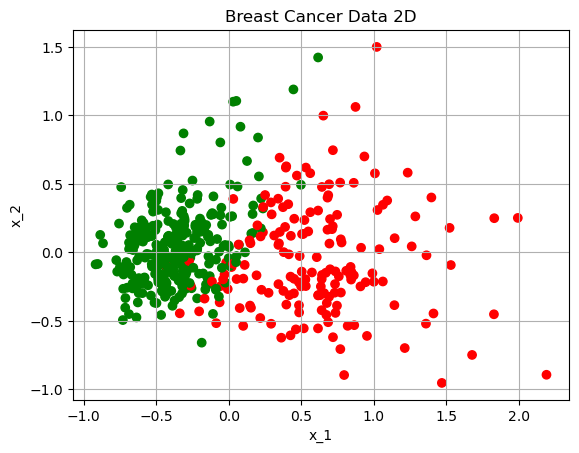

In [1220]:
clean_train_examples = train_examples.drop(columns='ones', inplace=False)
clean_test_examples = test_examples.drop(columns='ones', inplace=False)
pca = decomposition.PCA(n_components=8)
train_examples_pca = pca.fit_transform(clean_train_examples)
test_examples_pca = pca.fit_transform(clean_test_examples)

# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_
total_variance_explained = explained_variance.sum()

print(f"Explained variance by the first 8 components: {round(total_variance_explained*100,2)}")


print("\n2D PCA represents ~72% of data")
colors = np.where(train_labels == 0, 'red', 'green')

plt.scatter(train_examples_pca[:,0],train_examples_pca[:,1], marker='o', linestyle='', color=colors)
plt.title('Breast Cancer Data 2D')  
plt.xlabel('x_1')  
plt.ylabel('x_2')  
plt.grid()  

plt.show()

### Activation Functions

In [1221]:
def sigmoid(X,w):
    p = np.dot(w,X.T)
    return 1/(1 + np.exp(-p))

### Loss Functions

Cross Entropy Loss:
$$E(\textbf{w}) = -\frac{1}{m}\begin{pmatrix}\textbf{Y}^T\ln(\hat{\textbf{Y}})+ (1-\textbf{Y})^T - \ln(1-\hat{\textbf{Y}})\end{pmatrix}$$
$$\nabla E(\textbf{w})= \textbf{X}^T(\hat{\textbf{Y}} - \textbf{Y})$$

In [1222]:
def crossEntropyLoss(X,Y,w, display=True):
    m = X.shape[0]
    P = sigmoid(X,w)
    loss = - (1 / m) * (np.dot(Y.T, np.log(P)) + np.dot((1 - Y).T, np.log(1 - P)))
    return loss
    
def cross_entropy_loss_gradient(X,Y,w):
    p = sigmoid(X,w)
    return np.dot(np.transpose(X),(np.subtract(p,Y)))

### Gradient Descent

Weight update function:
$$\textbf{w}_{n+1} = \textbf{w}_n - \eta\nabla E(\textbf{w}_n)$$

In [1223]:
def gradient_descent(X,Y,w, eta=0.001, itr=250,record_every=15, display=True):

    errs, itrs = [], []

    for i in range(itr):
        w = np.add(w, ((-1*eta)*cross_entropy_loss_gradient(X,Y,w)))
        
        if ((i % record_every) == 0):
            current_loss = crossEntropyLoss(X,Y,w, display=False)
            errs.append(current_loss)
            itrs.append(i)
            if display:print(f"epoch {i} loss: {current_loss}") 
    return w, errs, itrs


def minibatch_gd(X,Y,w, eta=0.7, itr=250,record_every=15,batch_size=16, display=True):
    
    errs, itrs = [], []
    tset = list(range(X.shape[0]))

    for i in range(itr):
        idx = random.sample(tset, batch_size)
        #sample batch of data
        sample_X = X[idx, :]
        sample_y = y[idx]

        w = np.add(w, ((-1*eta)*cross_entropy_loss_gradient(sample_X,sample_y,w)))

        if ((i % record_every) == 0):
            current_loss = crossEntropyLoss(X,Y,w, display=False)
            errs.append(current_loss)
            itrs.append(i)
            if display:print(f"epoch {i} loss: {current_loss}") 

    return w, errs, itrs


### Calculating Accuracy

In [1224]:
def sigmoid_accuracy(X,Y,w):
    accuracy_vec = sigmoid(X,w)
    predictions = np.where(accuracy_vec < 0.5, 0, 1)
    correct = 0
    for i in range(X.shape[0]):
        if Y[i] == predictions[i]:
            correct += 1
    return  correct/X.shape[0]

### Training and testing the model


Gradient Descent
    Train Accuracy: 94.73%
    Test Accuracy: 95.61%

Minibatch Gradient Descent
    Train Accuracy: 97.8%
    Test Accuracy: 97.37%

Gradient Descent PCA
    Train Accuracy: 95.38%
    Test Accuracy: 98.25%

Minibatch Gradient Descent PCA
    Train Accuracy: 96.92%
    Test Accuracy: 96.49%


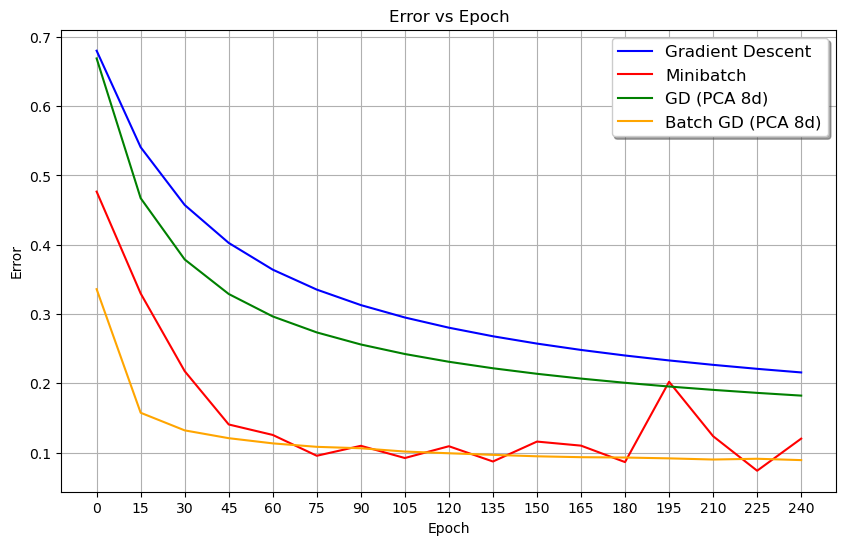

In [1225]:
w = np.random.randn(train_examples.shape[1]) * 0.01

train_examples = np.array(train_examples)
train_labels = np.array(train_labels)
test_examples = np.array(test_examples)
test_labels = np.array(test_labels)

w_pca = np.random.randn(train_examples_pca.shape[1]) * 0.01
train_examples_pca = np.array(train_examples_pca)



# Running Gradient Descent model
w_gd, errors_gd, epochs_gd = gradient_descent(train_examples,train_labels,w, display=False)
print()

# Calculating model accuracy
print("Gradient Descent")
train_accuracy = sigmoid_accuracy(train_examples,train_labels,w_gd)
print(f"    Train Accuracy: {round(train_accuracy*100,2)}%")

test_accuracy = sigmoid_accuracy(test_examples, test_labels, w_gd)
print(f"    Test Accuracy: {round(test_accuracy*100,2)}%")





# Running Minibatch Gradient Descent model
w_batch_gd, errors_batch_gd, epochs_batch_gd = minibatch_gd(train_examples,train_labels,w, display=False)
print()

# Calculating model accuracy
print("Minibatch Gradient Descent")
train_accuracy = sigmoid_accuracy(train_examples,train_labels,w_batch_gd)
print(f"    Train Accuracy: {round(train_accuracy*100,2)}%")

test_accuracy = sigmoid_accuracy(test_examples, test_labels, w_batch_gd)
print(f"    Test Accuracy: {round(test_accuracy*100,2)}%")




# Running Gradient Descent model with PCA data
w_gd_pca, errors_gd_pca, epochs_gd_pca = gradient_descent(train_examples_pca,train_labels,w_pca, display=False)
print()

# Calculating model accuracy
print("Gradient Descent PCA")
train_accuracy = sigmoid_accuracy(train_examples_pca,train_labels,w_gd_pca)
print(f"    Train Accuracy: {round(train_accuracy*100,2)}%")

test_accuracy = sigmoid_accuracy(test_examples_pca, test_labels, w_gd_pca)
print(f"    Test Accuracy: {round(test_accuracy*100,2)}%")




# Running Minibatch Gradient Descent model with PCA data
w_batch_gd_pca, errors_batch_gd_pca, epochs_batch_gd_pca = minibatch_gd(train_examples_pca,train_labels,w_pca, display=False)
print()

# Calculating model accuracy
print("Minibatch Gradient Descent PCA")
train_accuracy = sigmoid_accuracy(train_examples_pca,train_labels,w_batch_gd_pca)
print(f"    Train Accuracy: {round(train_accuracy*100,2)}%")

test_accuracy = sigmoid_accuracy(test_examples_pca, test_labels, w_batch_gd_pca)
print(f"    Test Accuracy: {round(test_accuracy*100,2)}%")




# Plotting error vs epochs
plt.figure(figsize=(10, 6)) 
plt.plot(epochs_gd, errors_gd, marker='', linestyle='-', color='b', label='Gradient Descent')
plt.plot(epochs_batch_gd, errors_batch_gd, marker='', linestyle='-', color='r', label='Minibatch')
plt.plot(epochs_gd_pca, errors_gd_pca, marker='', linestyle='-', color='g', label='GD (PCA 8d)')
plt.plot(epochs_batch_gd_pca, errors_batch_gd_pca, marker='', linestyle='-', color='orange', label='Batch GD (PCA 8d)')


plt.title('Error vs Epoch')  
plt.xlabel('Epoch')  
plt.ylabel('Error')  
plt.grid()  
plt.xticks(max(epochs_gd,epochs_batch_gd))
plt.legend(loc='upper right', fontsize='large', shadow=True)

plt.show()